# Loading and fitting observational data with Bagpipes

These exercises will take you through usage of the Bagpipes code to fit photometric and spectroscopic data. All the information you need to complete them should be available in the [Bagpipes documentation](https://bagpipes.readthedocs.io), or the [Jupyter notebook examples](https://github.com/ACCarnall/bagpipes/tree/master/examples) on the Bagpipes github repository. I'll be on hand during the session to discuss things with you, and provide advice if anything is confusing.

If you're new to Google Colab, this file is a Jupyter notebook running inside its own virtual machine on the Google servers, which I've pre-loaded with all the necessary software. This should allow you to get straight on with running the code without having to worry about installation issues. 

You can copy this document into your own Google drive to begin editing it. If you get into trouble, you can restart or factory reset the notebook/virtual machine under the Runtime menu at the top. You'll need to run the first code cell to install the necessary software before getting started.

In [1]:
# This first cell sets up the virtual machine with all the necessary software.
# There should be no need to edit this cell, just scroll down...

# Install Bagpipes and python dependencies
!pip install bagpipes

# Install MultiNest
!git clone https://www.github.com/johannesbuchner/multinest.git
!cd multinest/build && cmake .. && make && sudo make install

# Install PyMultiNest (with hacky solution to path issues)
!git clone https://www.github.com/ACCarnall/PyMultiNest
!cp -r PyMultiNest/pymultinest /usr/local/lib/python3.7/dist-packages/

# Install latex for plots
!sudo apt-get install texlive-latex-recommended 
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
!unzip type1cm.zip -d /tmp/type1cm 
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
!sudo mkdir /usr/share/texmf/tex/latex/type1cm 
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
!sudo texhash
!apt install cm-super

# Get the filter curves needed for the examples
!git clone https://github.com/ACCarnall/bagpipes
!mv bagpipes/examples/filters .
!rm -r bagpipes

# Adjust the output height to avoid a huge wall of installation text
from IPython import display
display.Javascript("google.colab.output.setIframeHeight('100px');")

     |████████████████████████████████| 206.0 MB 67 kB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 9.5 MB 28.6 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


Cloning into 'multinest'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 549 (delta 65), reused 49 (delta 19), pack-reused 431
Receiving objects: 100% (549/549), 300.02 KiB | 2.08 MiB/s, done.
Resolving deltas: 100% (342/342), done.
-- The Fortran compiler identification is GNU 7.5.0
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working Fortran compiler: /usr/bin/f95
-- Check for working Fortran compiler: /usr/bin/f95  -- works
-- Detecting Fortran compiler ABI info
-- Detecting Fortran compiler ABI info - done
-- Checking whether /usr/bin/f95 supports Fortran 90
-- Checking whether /usr/bin/f95 supports Fortran 90 -- yes
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features

<IPython.core.display.Javascript object>

In [2]:
# Import necessary python modules

import numpy as np
import bagpipes as pipes
import os

BAGPIPES: Generating IGM absorption table.


# Getting started

I've created a mystery galaxy using a subset of the filters and associated depths from the [CANDELS GOODS South catalogue](https://ui.adsabs.harvard.edu/abs/2013ApJS..207...24G/abstract). I've used the following photometric filter curves, which I've pre-loaded to the locations stored in filter_list below.

In this example you're going to try to recover the physical parameters of my mystery galaxy using Bagpipes. Along the way we'll have the chance to think about how the choices we make impact the parameter values we obtain.

In [3]:
filters = ["VIMOS_U", "f435w", "f606w", "f775w", "f850lp", "f098m", "f105w",
           "f125w", "f160w", "ISAAC_Ks", "HAWKI_K", "IRAC1", "IRAC2"]

filter_list = ["filters/" + f for f in filters]

The mock photometry in these filters is given below:

In [4]:
fluxes = np.array([0.0417, 0.0406, 0.0734, 0.2180, 0.4146, 0.4708,
                   0.6016, 0.8458, 1.2198, 2.1265, 2.0803, 3.5459,
                   2.6934]) #microJanskys

fluxerrs = np.array([0.0047, 0.0019, 0.0035, 0.0098, 0.0189, 0.0247,
                     0.0287, 0.0426, 0.0613, 0.1041, 0.1032, 0.3095,
                     0.2502]) #microJanskys


# Loading the mock data into bagpipes

First let's try loading these data into bagpipes and plotting them up using the code's inbuilt functions. You can see an example of how to do this in the 
second [Jupyter notebook example](https://github.com/ACCarnall/bagpipes/tree/master/examples) on the Bagpipes github repository.

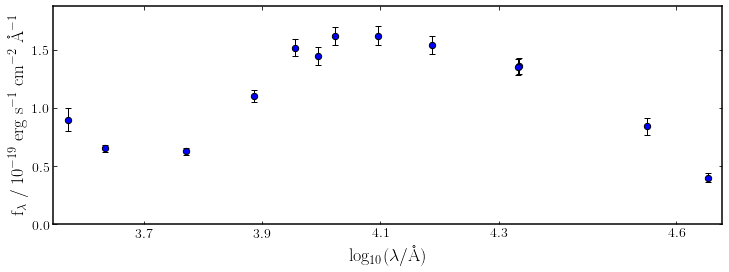

In [5]:
# Your code here

def load_data(ID):
    return np.c_[fluxes, fluxerrs]

galaxy = pipes.galaxy("mystery", load_data, filt_list=filter_list,
                      spectrum_exists=False)

fig = galaxy.plot()


# Building a model and fitting the data

Having done that, you should be ready to create a bagpipes fit object, passing in the data along with some fit instructions, and run the MultiNest sampler to fit my mock photometry. You can see hints on how to do this in the third and fourth [Jupyter notebook examples](https://github.com/ACCarnall/bagpipes/tree/master/examples) on the Bagpipes github repository. For this example it's probably best to start with an exponentially declining star formation history model and Calzetti dust model. Running the fit should take about 5-10 minutes for 6 free parameters.

In [6]:
# Your code here

exp = {}
exp["age"] = (0.1, 15.)
exp["tau"] = (0.3, 15.)
exp["massformed"] = (0., 13.)
exp["metallicity"] = (0.2, 2.5)

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 4.)

fit_info = {}
fit_info["exponential"] = exp
fit_info["nebular"] = nebular
fit_info["dust"] = dust
fit_info["redshift"] = (0., 10.)

fit = pipes.fit(galaxy, fit_info, run="test1")

fit.fit()



Bagpipes: fitting object mystery


Completed in 487.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        1.213      1.527      1.660
exponential:age                2.969      4.387      5.479
exponential:massformed         9.913     10.003     10.068
exponential:metallicity        0.550      0.778      1.242
exponential:tau                1.766      5.164     11.093
redshift                       0.920      0.958      1.005




# Making diagnostic plots and working with fit results

Once you've fitted the data it's time to take a look at the results. Bagpipes provides some standard plots for doing this, as well as direct access to the output of the sampling process. First, have a go at creating the standard spectrum posterior and corner plots the code provides. Please note that by default these plots are saved under "pipes/plots", rather than being shown. You'll need to set the keyword arguments save=False, show=True to get the plots to appear in Colab.

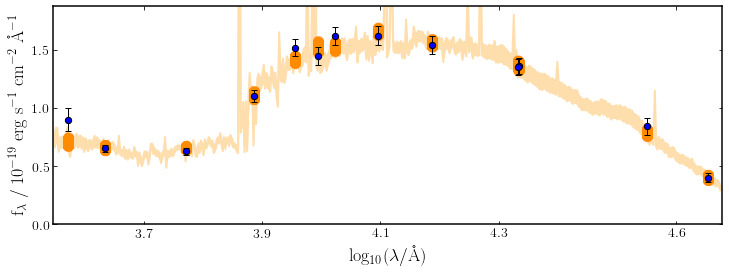

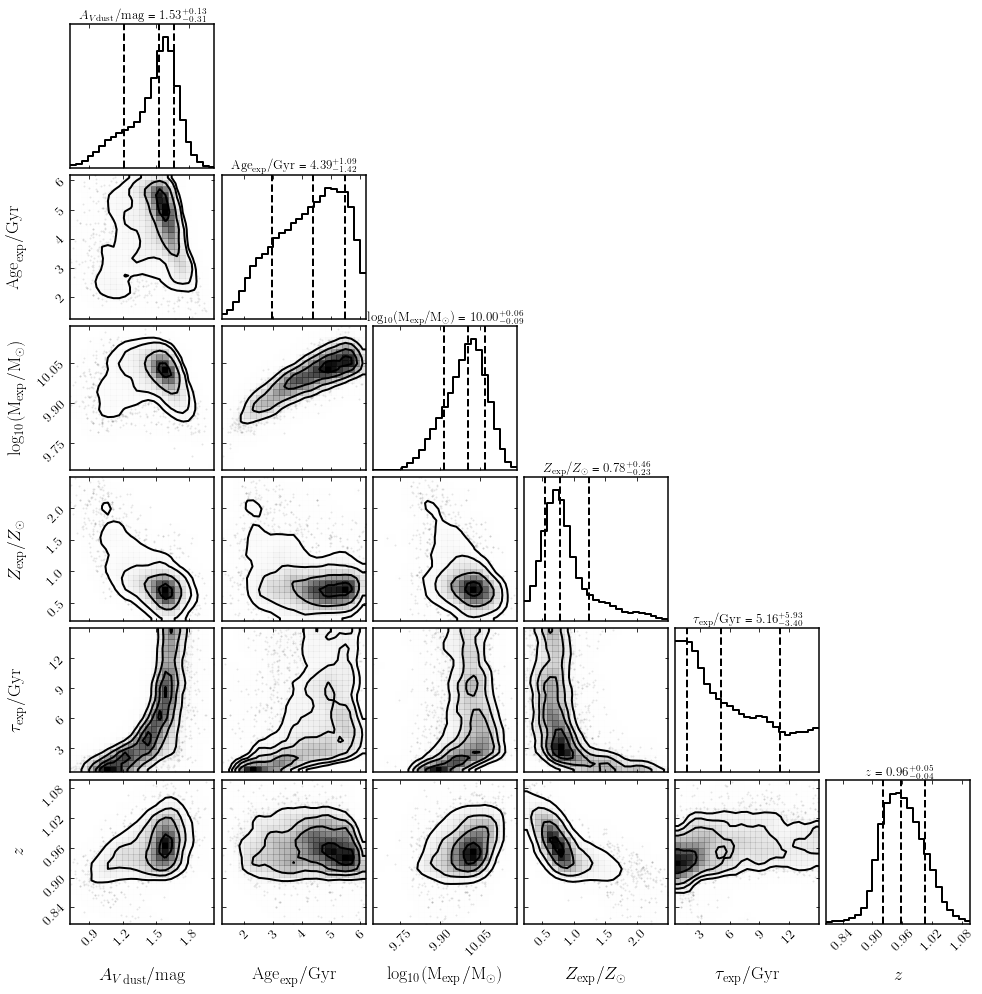

In [7]:
# Your code here

fig = fit.plot_spectrum_posterior(save=False, show=True)

fig = fit.plot_corner(save=False, show=True)


Once you've done that, try using the corner module to plot the "stellar_mass", "sfr" and "mass_weighted_age" posteriors provided by bagpipes. What are the 16th, 50th and 84th percentiles of the posterior distributions for these quantities?

In [8]:
# Your code here

print("Stellar mass percentiles: ", np.percentile(fit.posterior.samples["stellar_mass"], (16, 50, 84)))
print("SFR percentiles: ", np.percentile(fit.posterior.samples["sfr"], (16, 50, 84)))
print("Mass-weighted age percentiles: ", np.percentile(fit.posterior.samples["mass_weighted_age"], (16, 50, 84)))


Stellar mass percentiles:  [9.66329696 9.73222955 9.78818138]
SFR percentiles:  [0.77023928 1.40209203 1.91692139]
Mass-weighted age percentiles:  [1.72312876 2.5079166  3.12737188]


# But what does it mean?

Once you've got these numbers feel free to come and ask me for the values I used as input. Do your numbers match the input? Which parameters are best constrained and closest to the inputs? What happens when you change some of the priors and parameterisations you put into your fit above? You can also find the input parameters in the solutions notebook.

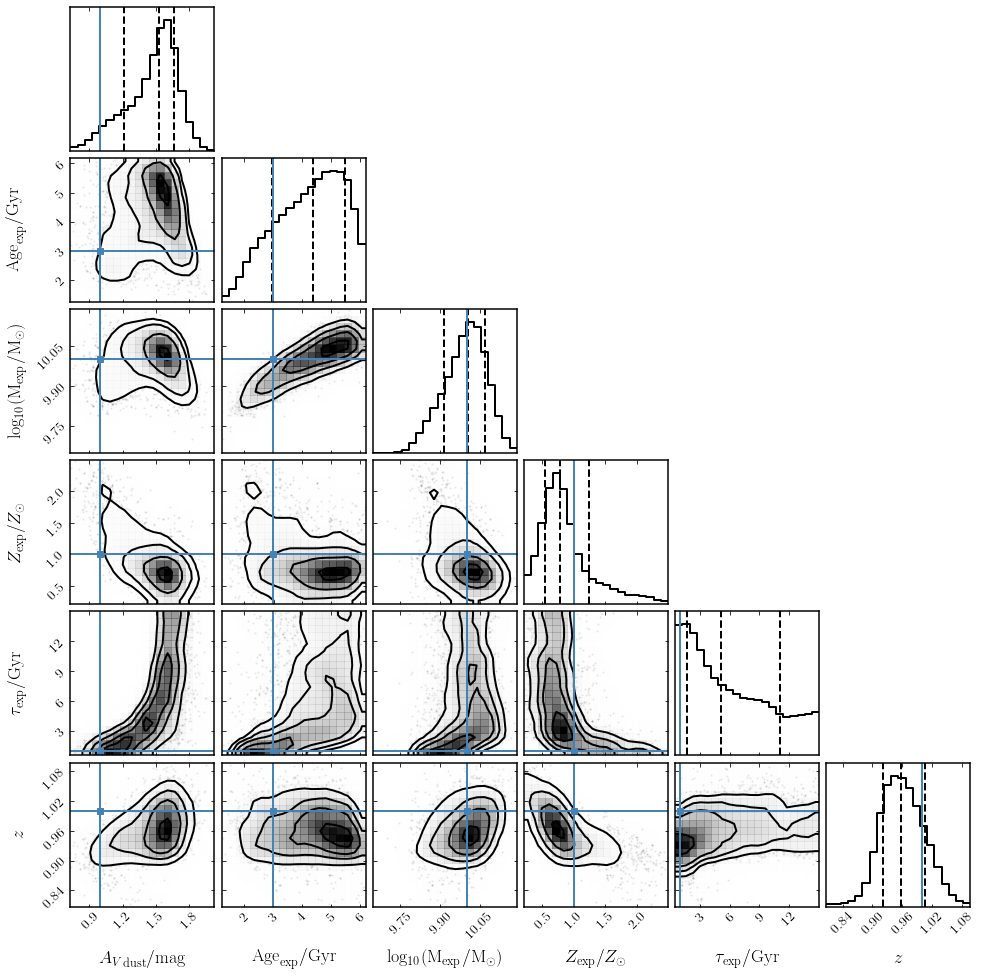

In [9]:
# Your code here

truths = [1., 3., 10., 1., 1., 1.] # These are the input parameter values I used

labels = pipes.plotting.fix_param_names(fit.fitted_model.params)

import corner
fig = corner.corner(fit.posterior.samples2d, truths=truths, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], smooth=1, smooth1d=1)


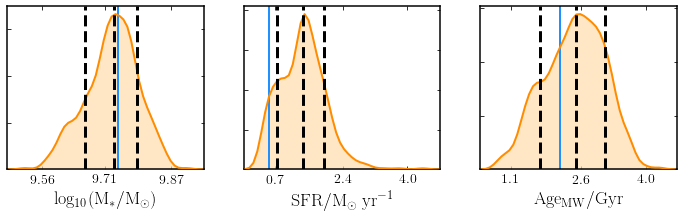

In [10]:
import matplotlib.pyplot as plt

# Re-generate the model_galaxy I used to create the input photometry
fit.fitted_model.lnlike(truths)
input_model = fit.fitted_model.model_galaxy

# Note this only works if you fitted with the same kind of model as my input
# i.e. Calzetti dust, tau model SFH, etc.

# Extract the true values of the relevant parameters
params = ["stellar_mass", "sfr", "mass_weighted_age"]

true_vals = [getattr(input_model.sfh, p) for p in params]

# Plot 1D histograms of posteriors from fit overlaid with the true values
import matplotlib as mpl
fig = plt.figure(figsize=(12, 3))
gs = mpl.gridspec.GridSpec(1, 3)

axes = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])]

for i in range(3):
    pipes.plotting.hist1d(fit.posterior.samples[params[i]], axes[i],
                          smooth=True, label=params[i])
    
    axes[i].axvline(true_vals[i], color="dodgerblue")
